In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.functional as F

import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

In [ ]:
seed = 22

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
path = '/content/drive/MyDrive/mujakjung/cloth/'

In [ ]:
image_label = pd.read_csv(path+'images.csv')
image_label

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False
...,...,...,...,...
5398,dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts,False
5399,befa14be-8140-4faf-8061-1039947e329d,204,Body,True
5400,5379356a-40ee-4890-b416-2336a7d84061,310,Shorts,False
5401,65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes,False


In [ ]:
cols = ['Not sure', 'Body', 'Other', 'Skip']
image_label = image_label.loc[~image_label['label'].isin(cols)]

In [ ]:
classes = image_label['label'].unique()
tmp = {}
for idx, c in enumerate(classes):
    tmp[c] = idx

image_label['label'] = image_label['label'].map(tmp)

<ipython-input-7-df36a62d9190>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_label['label'] = image_label['label'].map(tmp)


In [ ]:
train, test = train_test_split(image_label, test_size = 0.2, random_state=123, stratify=image_label['label'])
train.to_csv(path+'train.csv', index=False)
test.to_csv(path+'test.csv', index=False)

<BarContainer object of 16 artists>

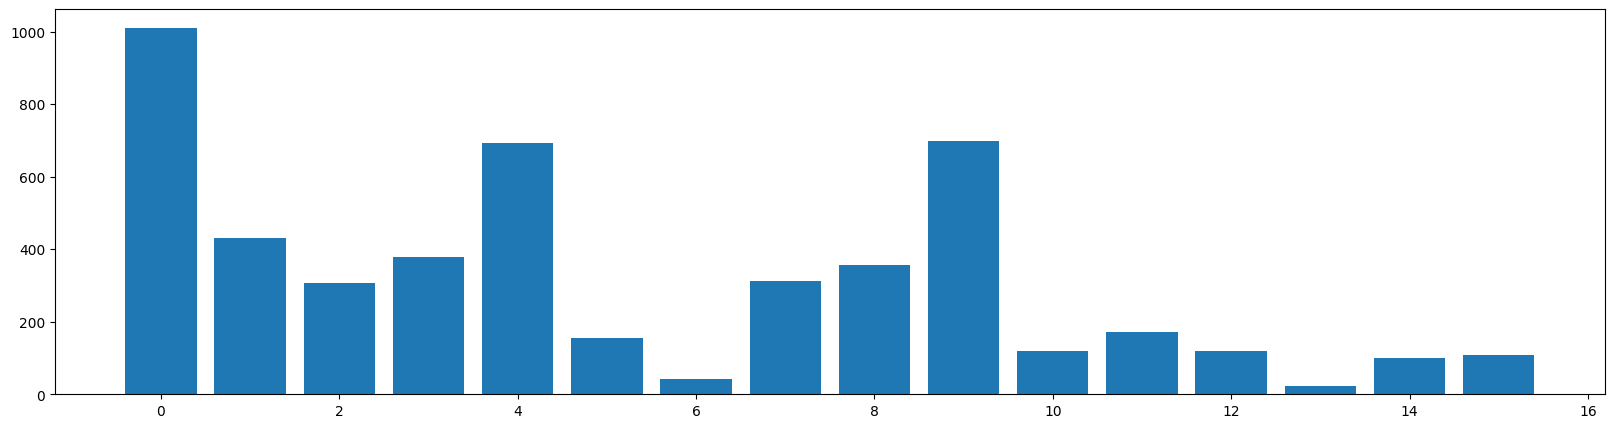

In [ ]:
plt.figure(figsize=(20,5))
plt.bar(x=image_label['label'].value_counts().index, height=image_label['label'].value_counts())

In [ ]:
class clothdataset():
    def __init__(self, path, csv_path, test=False, transform=None, target=None):
        self.path = path
        self.data = pd.read_csv(csv_path)
        self.transform = transform
        self.target = target
        self.test = test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.path + 'images_compressed/' + self.data.iloc[idx]['image'] + '.jpg'
        img = Image.open(img_path)
        if self.target:
            if self.target and self.data.iloc[idx]['label'] in self.target:
                img = self.transform[1](img)
            else:
                img = self.transform[0](img)
        else:
            img = self.transform(img)
        if self.test:
            return img
        else:
            img_label = self.data.iloc[idx]['label']
            return img, img_label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = clothdataset(path, path+'train.csv', test=False, transform=[transform, target_transform], target=[1,2,3,5,6,7,8,10,11,12,13,14,15])
test_dataset = clothdataset(path, path+'test.csv', test=False, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class ClothClassification(nn.Module):
    def __init__(self):
        super(ClothClassification, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 32, 3, 1)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32*218*218, 16)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 32*218*218)
        x = self.fc(x)
        return x

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt)**self.gamma * ce_loss
        if self.alpha is not None:
            focal_loss = self.alpha * focal_loss
        return focal_loss.mean()

focal_loss = FocalLoss(gamma=2, alpha=None)

In [ ]:
# criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if os.path.isfile(path+'checkpoint.pt'):
  checkpoint = torch.load(path+'checkpoint.pt')

model = ClothClassification()
if checkpoint:
  model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

criterion = focal_loss

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
if checkpoint:
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = 0
loss_list = []

if checkpoint:
  start_epoch = checkpoint['epoch']
  loss_list = checkpoint['loss']

In [ ]:
num_epoch = 100

In [ ]:
def train(train_dataloader, LOSS=None):
    for epoch in range(start_epoch, num_epoch):
        model.train()
        print(f'Epoch {epoch}/{num_epoch}')
        result = []
        y_result = []
        running_loss = 0
        for x, y in tqdm(train_dataloader):
            y_result += y
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            _, tmp_result = torch.max(output, 1)
            result += tmp_result.cpu()
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f1_score(result, y_result, average='macro'), running_loss/len(train_dataloader))

        if LOSS is None: LOSS = []
        LOSS.append(running_loss/len(train_dataloader))
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS
        }, path+'checkpoint.pt')

In [ ]:
train(train_dataloader, loss_list)

In [ ]:
pd.read_csv(path+'test.csv')

,image,sender_id,label,kids
0,fe21d6e5-b447-4ef4-ae4b-138cbf1a2220,116,0,False
1,85287925-224a-4f67-b34d-507b3859f962,48,12,False
2,6104b71c-017f-4631-95c9-6ff414091a7d,322,3,False
3,10e51a41-3729-472e-b288-f3b8f895577a,48,3,False
4,17e2ba0e-be9d-4fe4-b58b-2c039a693cb6,228,2,False
...,...,...,...,...
1001,df8283c4-33a7-4bc3-b2ef-2f9c62b15c18,262,8,False
1002,7e697e4d-ff1c-4478-85c6-a5715a1b3f31,48,0,False
1003,3bc940a9-c72f-4afb-ae60-6f65e01a507d,181,3,False
1004,cc0de3ab-d85a-45ff-93ea-d41520d09f1f,116,9,False


In [ ]:
model.eval()
correct = 0
total = 0
result = []
y_result = []

with torch.no_grad():
    for x, y in tqdm(test_dataloader):
        y_result += y.cpu()
        x, y = x.to(device), y.to(device)
        output = model(x)
        _, output = torch.max(output, 1)
        result += output.cpu()
print(f'F1 Score: {f1_score(result,y_result, average="macro")}')

100%|██████████| 32/32 [06:51<00:00, 12.86s/it]

F1 Score: 0.30576804877577113


In [ ]:
img = Image.open(path+'images_compressed/2df8bf1f-6d89-4acd-b6f6-9daec6b61b95.jpg')
plt.imshow(img)
a = transform(img)
model.eval()
a = a.to(device)
a = a.unsqueeze(0)
a = model(a)
a
idx, a = torch.max(a, 1)
print(key_tmp_value[a.tolist()[0]])

In [ ]:
key_tmp_value = {}
for k, v in tmp.items():
  key_tmp_value[v] = k